In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/var/folders/_v/78p688311b1406y84pvwbn4c0000gp/T/ipykernel_67740/2850567124.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
df_train = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/train.csv")
target_train = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/target_train.csv")
df_test = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/test.csv")
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv")

df_train_with_target = df_train.merge(target_train,on="ID")

df_all = pd.concat([df_train,df_test])

df_all_with_target = df_all.merge(target_train,how="left",on="ID")

In [3]:
df_all_with_target_fe = df_all_with_target.copy()

df_all_with_target_fe["expiry"] = df_all_with_target_fe["dt_expiry"] - df_all_with_target_fe["dt_close"]
df_all_with_target_fe["diff_high_low"] = df_all_with_target_fe["high"] - df_all_with_target_fe["low"]
df_all_with_target_fe["diff_close_open"] = df_all_with_target_fe["close"] - df_all_with_target_fe["open"]

df_all_with_target_fe["diff_high_low_angle"] = df_all_with_target_fe["diff_high_low"] / (df_all_with_target_fe["diff_high_low"] ** 2 + 1)
df_all_with_target_fe["diff_close_open_angle"] = df_all_with_target_fe["diff_close_open"] / (df_all_with_target_fe["diff_close_open"] ** 2 + 1)

df_all_with_target_fe["percent_high_low"] = df_all_with_target_fe["diff_high_low"] / df_all_with_target_fe["open"]
df_all_with_target_fe["percent_close_open"] = df_all_with_target_fe["diff_close_open"] / df_all_with_target_fe["open"]

In [4]:
def is_next_period(row, max_ex, min_ex):
    #if row["expiry"] > max_ex * 0.3 and (row["expiry"] - row["last_expiry"]) > (max_ex-min_ex) * 0.3:
    if row["expiry"] - row["last_expiry"] > 0:
        return 1
    else: return 0
    
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank].sort_values("dt_close")
        df_pid_rank["last_expiry"] = df_pid_rank["expiry"].shift(1)
        max_ex, min_ex = df_pid_rank["expiry"].max(),df_pid_rank["expiry"].min()
        df_pid_rank["num_period"] = df_pid_rank.apply(is_next_period,axis=1, args=(max_ex, min_ex)).cumsum()
        df_all_with_target_fe.loc[df_pid_rank.index,"num_period"] = df_pid_rank["num_period"]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.77it/s]


In [5]:
df_all_with_target_fe[(df_all_with_target_fe.product_id==401920) & (df_all_with_target_fe.liquidity_rank==2)].sort_values("dt_close")

,ID,dt_close,product_id,liquidity_rank,normal_trading_day,dt_expiry,open,high,low,close,...,fixed,spread,expiry,diff_high_low,diff_close_open,diff_high_low_angle,diff_close_open_angle,percent_high_low,percent_close_open,num_period
2,2,8862,401920,2,1,9039,2530.0,2550.0,2468.0,2478.0,...,0,5.351175,177,82.0,-52.0,0.012193,-0.019224,0.032411,-0.020553,0.0
255,255,8863,401920,2,1,9039,2500.0,2540.0,2500.0,2519.0,...,0,4.811636,176,40.0,19.0,0.024984,0.052486,0.016000,0.007600,0.0
576,576,8864,401920,2,1,9039,2533.0,2553.0,2479.0,2481.0,...,0,2.868590,175,74.0,-52.0,0.013511,-0.019224,0.029214,-0.020529,0.0
878,878,8865,401920,2,1,9039,2463.0,2482.0,2447.0,2452.0,...,0,2.913726,174,35.0,-11.0,0.028548,-0.090164,0.014210,-0.004466,0.0
1200,1200,8866,401920,2,1,9039,2430.0,2474.0,2417.0,2421.0,...,0,2.410022,173,57.0,-9.0,0.017538,-0.109756,0.023457,-0.003704,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859717,857923,11447,401920,2,1,11604,1927.0,1960.0,1927.0,1952.0,...,0,NaN,157,33.0,25.0,0.030275,0.039936,0.017125,0.012974,39.0
628046,858263,11448,401920,2,1,11604,1956.0,1976.0,1952.0,1973.0,...,0,1.261974,156,24.0,17.0,0.041594,0.058621,0.012270,0.008691,39.0
628296,858600,11449,401920,2,1,11604,1972.0,1974.0,1931.0,1936.0,...,0,1.299037,155,43.0,-36.0,0.023243,-0.027756,0.021805,-0.018256,39.0
628644,858948,11450,401920,2,1,11604,1950.0,1955.0,1915.0,1918.0,...,0,1.232085,154,40.0,-32.0,0.024984,-0.031220,0.020513,-0.016410,39.0


In [6]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


dict_agg = {
            "period_high_std" : pd.NamedAgg(column="high", aggfunc=np.std),
            "period_low_std" : pd.NamedAgg(column="low", aggfunc=np.std),
            "period_open_std" : pd.NamedAgg(column="open", aggfunc=np.std),
            "period_close_std" : pd.NamedAgg(column="close", aggfunc=np.std),
            "period_dco_std" : pd.NamedAgg(column="diff_close_open", aggfunc=np.std),
            "period_dhl_std" : pd.NamedAgg(column="diff_high_low", aggfunc=np.std),

            "period_phl_mean" : pd.NamedAgg(column="percent_high_low", aggfunc=np.mean),
            "period_phl_std" : pd.NamedAgg(column="percent_high_low", aggfunc=np.std),   
            "period_pco_mean" : pd.NamedAgg(column="percent_close_open", aggfunc=np.mean),
            "period_pco_std" : pd.NamedAgg(column="percent_close_open", aggfunc=np.std),   
            "period_interest_mean" : pd.NamedAgg(column="open_interest", aggfunc=np.mean),
            "period_interest_std" : pd.NamedAgg(column="open_interest", aggfunc=np.std), 
            "period_interest_quantile25" : pd.NamedAgg(column="open_interest", aggfunc=percentile(25)),
            "period_interest_quantile75" : pd.NamedAgg(column="open_interest", aggfunc=percentile(75)),
            "period_volume_mean" : pd.NamedAgg(column="volume", aggfunc=np.mean),
            "period_volume_std" : pd.NamedAgg(column="volume", aggfunc=np.std), 
            "period_volume_quantile25" : pd.NamedAgg(column="volume", aggfunc=percentile(25)),
            "period_volume_quantile75" : pd.NamedAgg(column="volume", aggfunc=percentile(75)),
}
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_mean_std = df_pid_rank.groupby("num_period").agg(
                                                            **dict_agg
                                                            )
        df_pid_rank_period_merge = df_pid_rank[["num_period"]].merge(period_mean_std,how="left",left_on="num_period",right_index=True).drop("num_period",axis=1)
        df_all_with_target_fe.loc[df_pid_rank.index,df_pid_rank_period_merge.columns] = df_pid_rank_period_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:16<00:00,  6.29it/s]


In [7]:
dict_rename1 = {"high":"high_diff","low":"low_diff","open":"open_diff","close":"close_diff","diff_close_open":"diff_close_open_diff","diff_high_low":"diff_high_low_diff","volume":"volume_diff"}
dict_rename2 = {"high":"high_diff_angle","low":"low_diff_angle","open":"open_diff_angle","close":"close_diff_angle","diff_close_open":"diff_close_open_diff_angle","diff_high_low":"diff_high_low_diff_angle","volume":"volume_diff_angle"}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_diff = df_pid_rank.groupby("num_period")[["high","low","open","close","diff_close_open","diff_high_low","volume"]].diff(1)
        period_diff_1 = period_diff.rename(dict_rename1,axis=1)
        df_all_with_target_fe.loc[period_diff_1.index,period_diff_1.columns] = period_diff_1
        
        period_diff_2 = (period_diff / (period_diff ** 2 + 1)).rename(dict_rename2,axis=1)
        df_all_with_target_fe.loc[period_diff_2.index,period_diff_2.columns] = period_diff_2
        
        
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 28.99it/s]


In [10]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

dict_agg = {
            "period_high_std" : pd.NamedAgg(column="high", aggfunc=np.std),
            "period_low_std" : pd.NamedAgg(column="low", aggfunc=np.std),
            "period_open_std" : pd.NamedAgg(column="open", aggfunc=np.std),
            "period_close_std" : pd.NamedAgg(column="close", aggfunc=np.std),
            "period_dco_std" : pd.NamedAgg(column="diff_close_open", aggfunc=np.std),
            "period_dhl_std" : pd.NamedAgg(column="diff_high_low", aggfunc=np.std),

            "period_phl_mean" : pd.NamedAgg(column="percent_high_low", aggfunc=np.mean),
            "period_phl_std" : pd.NamedAgg(column="percent_high_low", aggfunc=np.std),   
            "period_pco_mean" : pd.NamedAgg(column="percent_close_open", aggfunc=np.mean),
            "period_pco_std" : pd.NamedAgg(column="percent_close_open", aggfunc=np.std),   
            "period_interest_mean" : pd.NamedAgg(column="open_interest", aggfunc=np.mean),
            "period_interest_std" : pd.NamedAgg(column="open_interest", aggfunc=np.std), 
            "period_interest_quantile25" : pd.NamedAgg(column="open_interest", aggfunc=percentile(25)),
            "period_interest_quantile75" : pd.NamedAgg(column="open_interest", aggfunc=percentile(75)),
            "period_volume_mean" : pd.NamedAgg(column="volume", aggfunc=np.mean),
            "period_volume_std" : pd.NamedAgg(column="volume", aggfunc=np.std), 
            "period_volume_quantile25" : pd.NamedAgg(column="volume", aggfunc=percentile(25)),
            "period_volume_quantile75" : pd.NamedAgg(column="volume", aggfunc=percentile(75)),
}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        expiry_mean_std = df_pid_rank.groupby("expiry").agg(**dict_agg)
        df_pid_rank_expiry_merge = df_pid_rank[["expiry"]].merge(expiry_mean_std,how="left",left_on="expiry",right_index=True).drop("expiry",axis=1)
        df_all_with_target_fe.loc[df_pid_rank.index,df_pid_rank_expiry_merge.columns] = df_pid_rank_expiry_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.96it/s]


In [11]:
df_learn_clean = pd.read_pickle("df_mask_pid5.pkl")

In [82]:
cols_spread = [col for col in df_learn_clean if col.startswith('spread_')] + [col for col in df_learn_clean if col.startswith('interp')] + [col for col in df_learn_clean if col.endswith('_spread')]
#cols_conserved = cols_spread + list(df_train_with_target.columns)
cols_conserved = cols_spread + ["ID"]

In [32]:
base_cols = list(df_train_with_target.columns.drop("ID"))

In [33]:
df_learn_clean_new = df_learn_clean.drop(base_cols,axis=1).merge(df_all_with_target_fe,on="ID",how="left")

In [70]:
df_learn_clean_new

,ID,expiry_x,diff_high_low_x,diff_close_open_x,diff_high_low_tick,diff_close_open_tick,percent_high_low_x,percent_close_open_x,volume_sum_3,volume_mean_3,...,diff_close_open_diff,diff_high_low_diff,volume_diff,high_diff_angle,low_diff_angle,open_diff_angle,close_diff_angle,diff_close_open_diff_angle,diff_high_low_diff_angle,volume_diff_angle
0,25431,8,20.0,7.0,1.818182,0.636364,0.008147,0.002851,1004.0,334.666667,...,6.0,-32.0,-283.0,-0.123077,0.041594,0.123077,0.071066,0.162162,-0.031220,-0.003534
1,25432,51,22.0,4.0,2.000000,0.363636,0.009271,0.001686,1453.0,484.333333,...,9.0,-21.0,-156.0,-0.400000,0.052486,0.235294,0.076471,0.109756,-0.047511,-0.006410
2,25433,95,17.0,1.0,1.545455,0.090909,0.007343,0.000432,684.0,228.000000,...,-11.0,-14.0,-89.0,-0.192308,0.109756,0.076471,0.400000,-0.090164,-0.071066,-0.011235
3,25434,160,17.0,4.0,1.545455,0.363636,0.007246,0.001705,384.0,128.000000,...,-6.0,-10.0,13.0,-0.235294,0.162162,0.123077,0.400000,-0.162162,-0.099010,0.076471
4,25435,269,18.0,15.0,1.636364,1.363636,0.007484,0.006237,221.0,73.666667,...,3.0,-10.0,21.0,-0.123077,0.400000,-0.162162,-0.300000,0.300000,-0.099010,0.047511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071792,843750,26,60.0,-27.0,4.285714,-1.928571,0.009901,-0.004455,16308.0,5436.000000,...,-44.0,6.0,777.0,0.066372,0.109756,0.023796,-0.400000,-0.022716,0.162162,0.001287
2071793,844105,3,92.0,-87.0,6.571429,-6.214286,0.015040,-0.014223,54237.0,18079.000000,...,-59.0,29.0,18714.0,-0.031220,-0.016389,-0.140000,-0.015148,-0.016944,0.034442,0.000053
2071794,844106,25,92.0,-74.0,6.571429,-5.285714,0.015219,-0.012242,33699.0,11233.000000,...,-47.0,32.0,13926.0,-0.036986,-0.016944,-0.066372,-0.016125,-0.021267,0.031220,0.000072
2071795,844454,2,70.0,-40.0,5.000000,-2.857143,0.011542,-0.006595,57267.0,19089.000000,...,47.0,-22.0,-2151.0,-0.031220,-0.099010,-0.019224,-0.192308,0.021267,-0.045361,-0.000465


In [83]:
df_learn_clean_new_nospread = df_learn_clean_new.drop(cols_spread,axis=1)

In [84]:
# with old features
features = df_learn_clean_new_nospread.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

#id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new_nospread[df_learn_clean_new_nospread["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new_nospread[df_learn_clean_new_nospread["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new_nospread.loc[train_idx, features],
                            df_learn_clean_new_nospread.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new_nospread.loc[valid_idx, features], 
                          df_learn_clean_new_nospread.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.707828	vl's rmse: 0.770637
[200]	tr's rmse: 0.628278	vl's rmse: 0.732393
[300]	tr's rmse: 0.579645	vl's rmse: 0.715352
[400]	tr's rmse: 0.542549	vl's rmse: 0.704551
[500]	tr's rmse: 0.513101	vl's rmse: 0.698016
[600]	tr's rmse: 0.487634	vl's rmse: 0.69313
[700]	tr's rmse: 0.465808	vl's rmse: 0.690056
[800]	tr's rmse: 0.445248	vl's rmse: 0.687529
[900]	tr's rmse: 0.425039	vl's rmse: 0.68491
[1000]	tr's rmse: 0.409777	vl's rmse: 0.683503
[1100]	tr's rmse: 0.392374	vl's rmse: 0.68213
[1200]	tr's rmse: 0.377611	vl's rmse: 0.680859
[1300]	tr's rmse: 0.363179	vl's rmse: 0.67976
[1400]	tr's rmse: 0.351015	vl's rmse: 0.678849
[1500]	tr's rmse: 0.339119	vl's rmse: 0.678086
[1600]	tr's rmse: 0.328403	vl's rmse: 0.677412
[1700]	tr's rmse: 0.317843	vl's rmse: 0.676892
[1800]	tr's rmse: 0.307938	vl's rmse: 0.676408
[1900]	tr's rmse: 0.298318	vl's rmse: 0.675735
[2000]	tr's rmse: 0.288874	vl's rmse: 0.67529
[2100]	tr's r

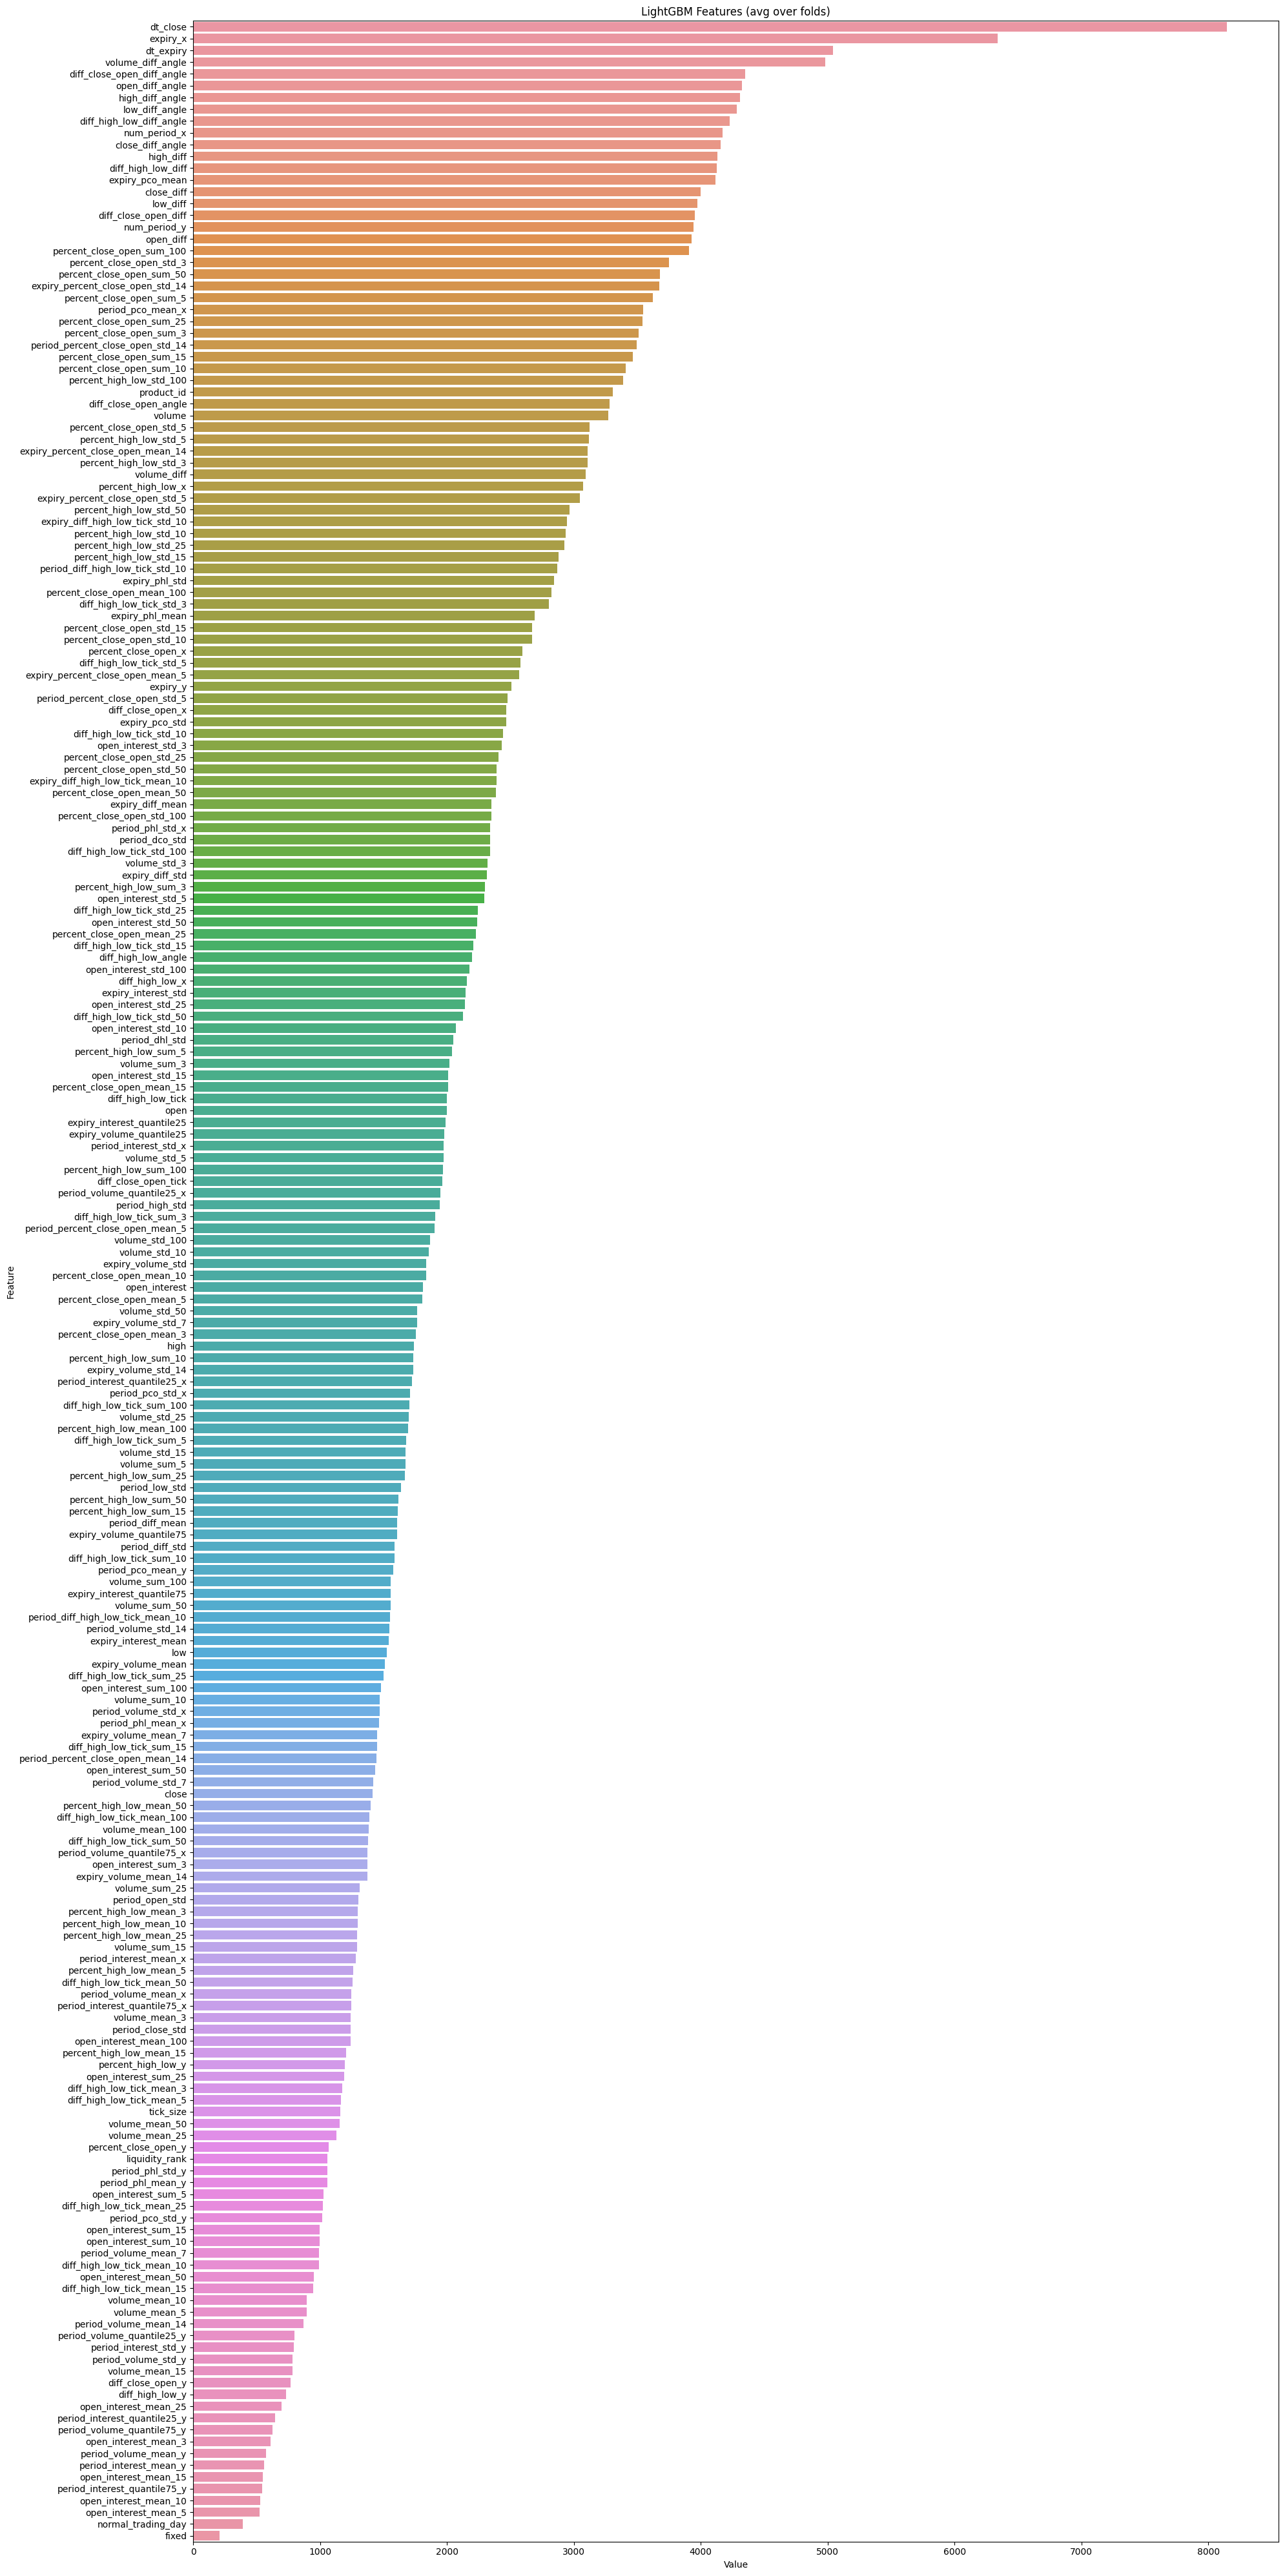

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_all.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [35]:
# with old features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

#id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.634445	vl's rmse: 0.712329
[200]	tr's rmse: 0.574196	vl's rmse: 0.699452
[300]	tr's rmse: 0.529567	vl's rmse: 0.693513
[400]	tr's rmse: 0.493295	vl's rmse: 0.688796
[500]	tr's rmse: 0.461259	vl's rmse: 0.685122
[600]	tr's rmse: 0.434111	vl's rmse: 0.682337
[700]	tr's rmse: 0.413059	vl's rmse: 0.680708
[800]	tr's rmse: 0.393465	vl's rmse: 0.679003
[900]	tr's rmse: 0.374804	vl's rmse: 0.677533
[1000]	tr's rmse: 0.358702	vl's rmse: 0.676558
[1100]	tr's rmse: 0.344209	vl's rmse: 0.675553
[1200]	tr's rmse: 0.330442	vl's rmse: 0.674696
[1300]	tr's rmse: 0.318447	vl's rmse: 0.673962
[1400]	tr's rmse: 0.307074	vl's rmse: 0.673288
[1500]	tr's rmse: 0.296204	vl's rmse: 0.672588
[1600]	tr's rmse: 0.285865	vl's rmse: 0.672094
[1700]	tr's rmse: 0.276342	vl's rmse: 0.671677
[1800]	tr's rmse: 0.267666	vl's rmse: 0.671136
[1900]	tr's rmse: 0.259491	vl's rmse: 0.670699
[2000]	tr's rmse: 0.252187	vl's rmse: 0.670391
[2100]	t

In [38]:
df_test_all = pd.read_pickle("df_test_mask_pid5.pkl")

In [39]:
df_test_all_c = df_test_all.drop(base_cols,axis=1).merge(df_all_with_target_fe,on="ID",how="left")

In [41]:
features = df_test_all_c.columns.drop(["ID","spread"])

In [42]:
pred = model_all.predict(df_test_all_c[features])

In [46]:
s_pred = pd.Series(pred,index=df_test_all_c.index,name="spread")
df_pred = pd.concat([s_pred,df_test_all_c["ID"]],axis=1)

In [48]:
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_pred[["ID","spread"]],on="ID")

In [49]:
sub_new

,ID,spread
0,1977,1.834318
1,1978,2.524451
2,1979,3.420843
3,1980,3.377366
4,1981,3.937098
...,...,...
230299,858592,1.023956
230300,858593,1.038129
230301,858594,1.076841
230302,858595,1.099678


In [56]:
sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

In [57]:
sub_old

,ID,spread
0,1977,1.558859
1,1978,2.332640
2,1979,2.773326
3,1980,2.975560
4,1981,3.656509
...,...,...
230299,858592,1.042356
230300,858593,1.057847
230301,858594,1.125660
230302,858595,1.104639


In [86]:
np.mean((sub_new["spread"] - sub_old["spread"]) ** 2)

0.04103952796519756

In [59]:
xx = (sub_new["spread"] + sub_old["spread"]) / 2

In [62]:
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)

In [64]:
sub["spread"] = xx

In [65]:
sub

,ID,spread
0,1977,1.696589
1,1978,2.428545
2,1979,3.097084
3,1980,3.176463
4,1981,3.796804
...,...,...
230299,858592,1.033156
230300,858593,1.047988
230301,858594,1.101250
230302,858595,1.102159


In [68]:
aa = sub[sub.spread< 1]
sub.loc[aa.index,"spread"] = 1
bb = sub[sub.spread> 10]
sub.loc[bb.index,"spread"] = 10

In [69]:
sub.to_csv("feifei_first_try.csv",index=False)

In [28]:
# add new features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

#id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.648049	vl's rmse: 0.718201
[200]	tr's rmse: 0.590866	vl's rmse: 0.707584
[300]	tr's rmse: 0.550054	vl's rmse: 0.702998
[400]	tr's rmse: 0.516198	vl's rmse: 0.700302
[500]	tr's rmse: 0.486606	vl's rmse: 0.697812
[600]	tr's rmse: 0.461969	vl's rmse: 0.696529
[700]	tr's rmse: 0.440006	vl's rmse: 0.69535
[800]	tr's rmse: 0.419205	vl's rmse: 0.694717
[900]	tr's rmse: 0.401892	vl's rmse: 0.693682
[1000]	tr's rmse: 0.384511	vl's rmse: 0.693044
[1100]	tr's rmse: 0.36921	vl's rmse: 0.692181
[1200]	tr's rmse: 0.355079	vl's rmse: 0.691741
[1300]	tr's rmse: 0.34234	vl's rmse: 0.691332
[1400]	tr's rmse: 0.331031	vl's rmse: 0.69073
[1500]	tr's rmse: 0.320405	vl's rmse: 0.690288
[1600]	tr's rmse: 0.30987	vl's rmse: 0.689837
[1700]	tr's rmse: 0.300839	vl's rmse: 0.689524
[1800]	tr's rmse: 0.292237	vl's rmse: 0.689158
[1900]	tr's rmse: 0.283496	vl's rmse: 0.688817
[2000]	tr's rmse: 0.274815	vl's rmse: 0.688453
[2100]	tr's r

In [24]:
# add new features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.722628	vl's rmse: 0.742485
[200]	tr's rmse: 0.690574	vl's rmse: 0.731967
[300]	tr's rmse: 0.665917	vl's rmse: 0.726289
[400]	tr's rmse: 0.645618	vl's rmse: 0.722807
[500]	tr's rmse: 0.627267	vl's rmse: 0.71968
[600]	tr's rmse: 0.611184	vl's rmse: 0.716896
[700]	tr's rmse: 0.596643	vl's rmse: 0.714742
[800]	tr's rmse: 0.58284	vl's rmse: 0.712978
[900]	tr's rmse: 0.570227	vl's rmse: 0.711616
[1000]	tr's rmse: 0.557863	vl's rmse: 0.710116
[1100]	tr's rmse: 0.547329	vl's rmse: 0.708852
[1200]	tr's rmse: 0.536701	vl's rmse: 0.707562
[1300]	tr's rmse: 0.526832	vl's rmse: 0.706762
[1400]	tr's rmse: 0.517594	vl's rmse: 0.706056
[1500]	tr's rmse: 0.508368	vl's rmse: 0.705274
[1600]	tr's rmse: 0.499417	vl's rmse: 0.704382
[1700]	tr's rmse: 0.491338	vl's rmse: 0.703928
[1800]	tr's rmse: 0.483599	vl's rmse: 0.703329
[1900]	tr's rmse: 0.476164	vl's rmse: 0.702771
[2000]	tr's rmse: 0.468999	vl's rmse: 0.702273
[2100]	tr'

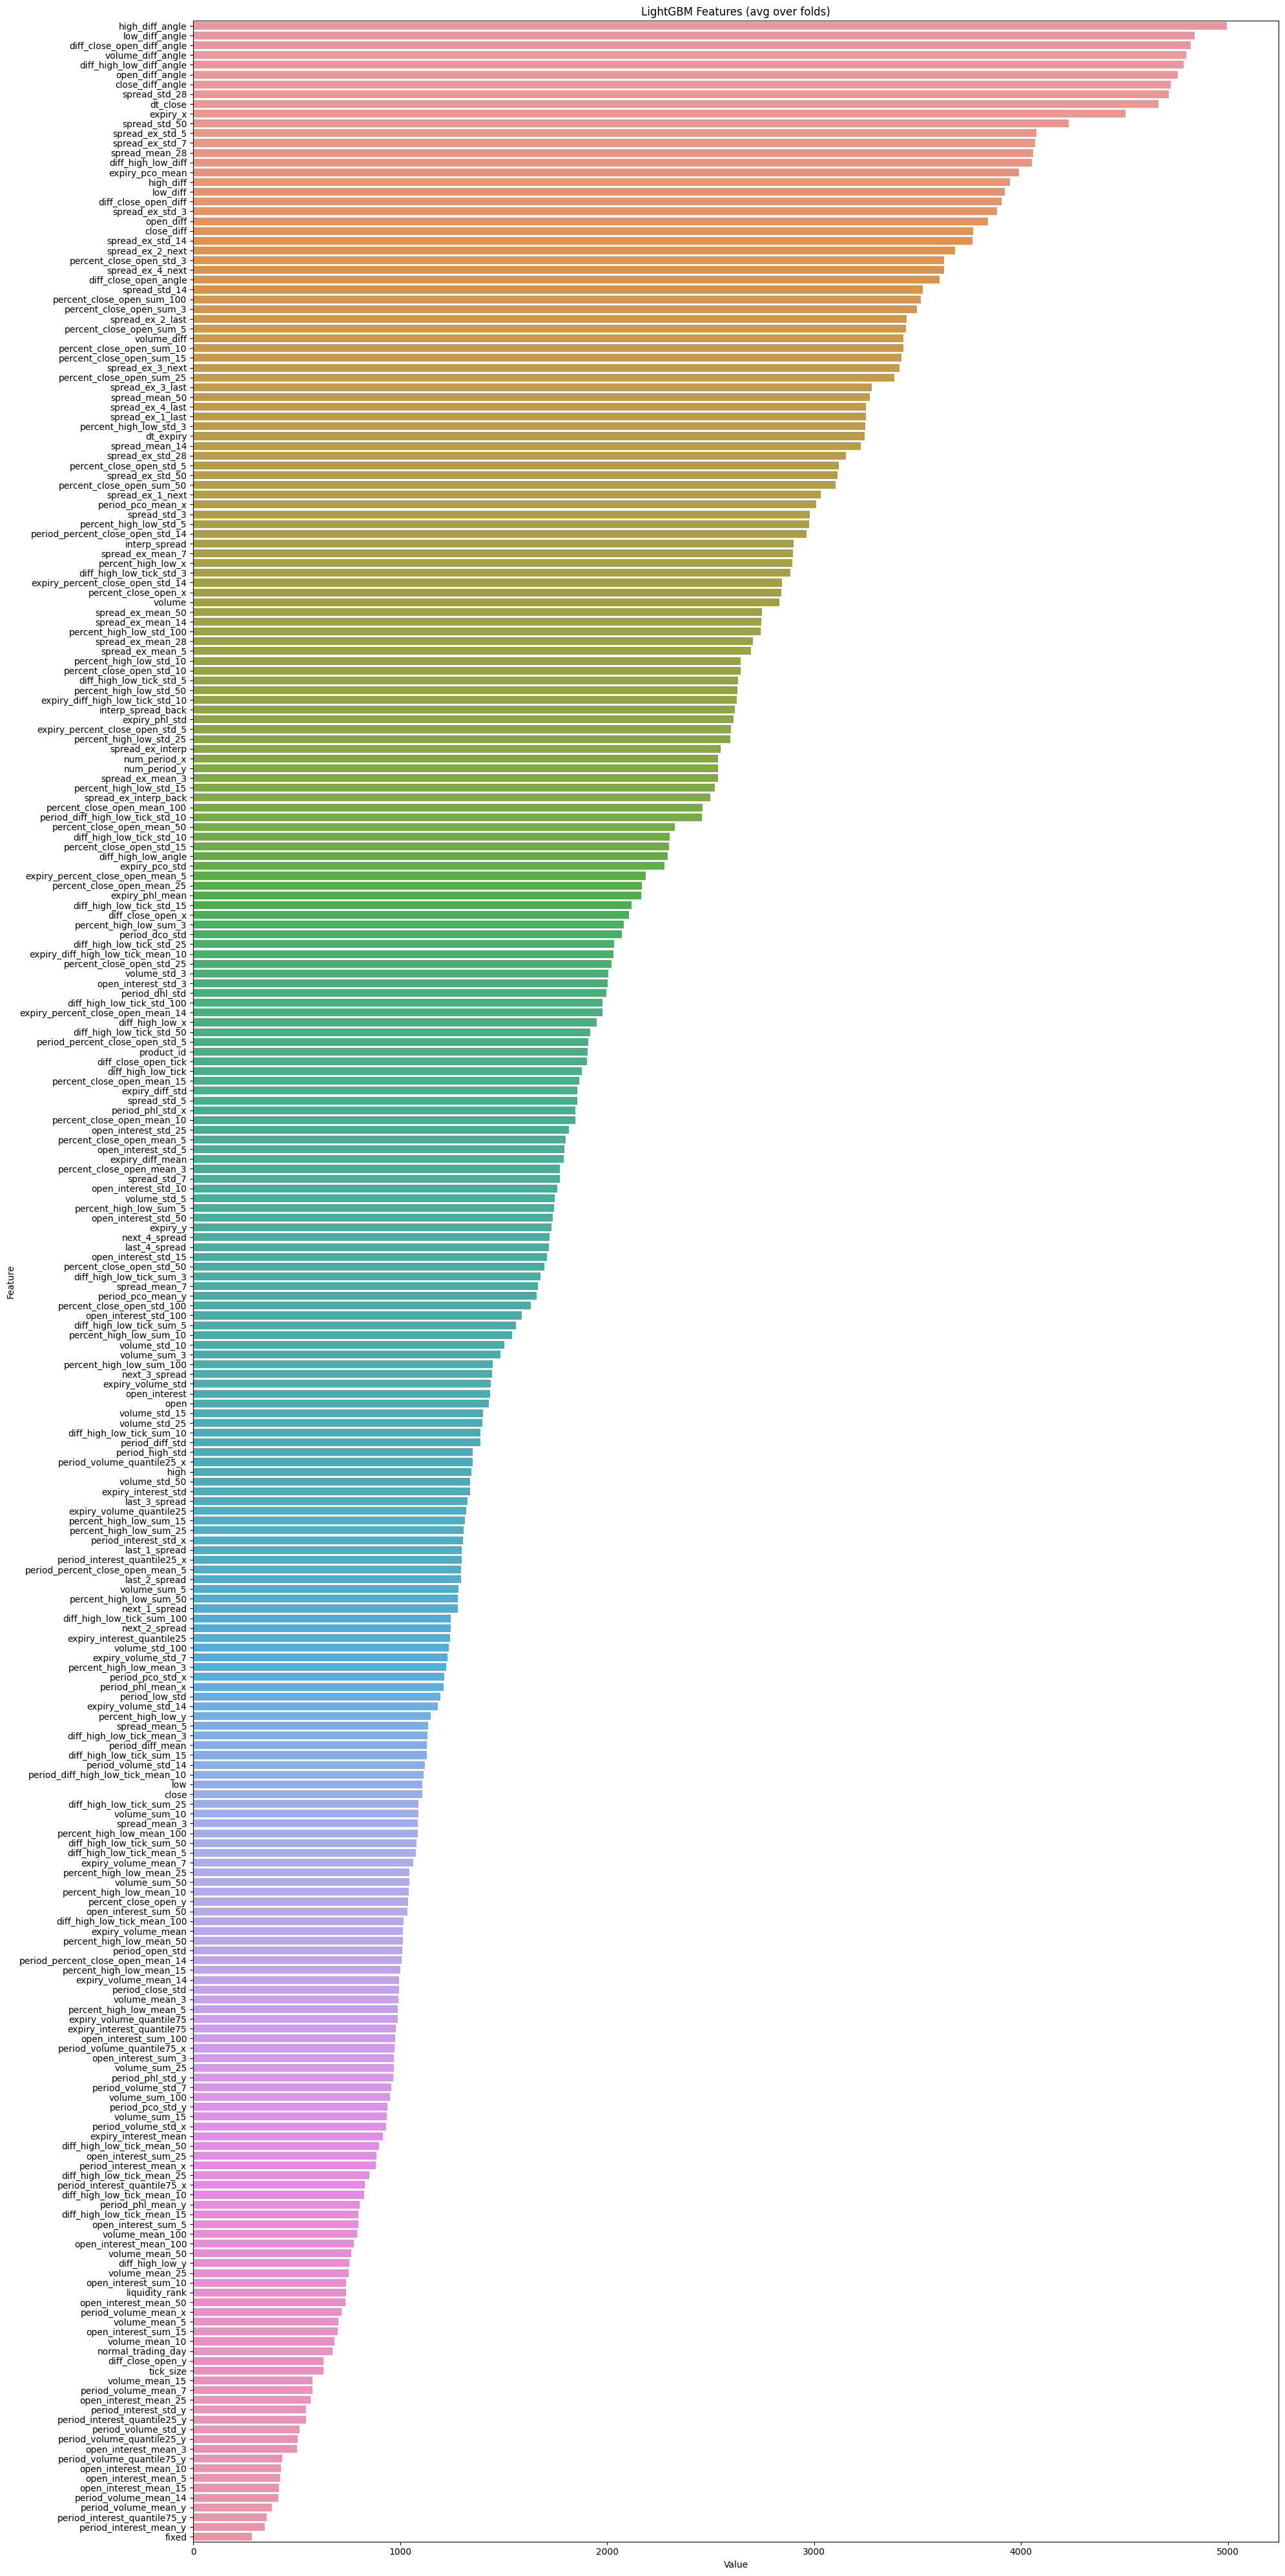

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_all.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()